In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

In [128]:
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax,create_data_2d
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *

We want to get a threshold and error bound for analysing a analytic or polynomial PDE as unique. We can reuse the functions from the SFranco method.

### Easy examples: $u_1 = x^2 + t^2$ and $u_2 = exp(x-at)$

In [246]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-2, T_end=2, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
"""
#not unique
u = X**2 + T**2
ux = 2*X
ut = 2*T
utx = 0*T
uxx = 2*np.ones(X.shape)
"""

#not unqiue
u = np.exp(X-a*T)
ux = u
ut = -a*u
utx = -a*u
uxx = u
"""
#analytic unique
u=(X + T)*np.arccos(1/np.cosh(a*T))
ut = a*(T + X)*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2) + np.arccos(1/np.cosh(T*a))
ux = np.arccos(1/np.cosh(T*a))
utx = a*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2)
uxx = np.zeros(X.shape)
"""
dt=t[1]-t[0]
dx=x[1]-x[0]

#### Compare the error on finite differences on the Jacobian of $g = ( u | u_x)$

In [249]:
#Compare the derivatives
fd_order=2
ut_fd = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u, t=dt)
utx_fd = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut_fd, dx)
ux_fd = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
uxx_fd = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u, dx) 

print(f" |ut_fd - ut | = {np.linalg.norm(ut_fd-ut):.3e}")
print(f" |utx_fd - utx | = {np.linalg.norm(utx_fd-utx):.3e}")
print(f" |ux_fd - ux | = {np.linalg.norm(ux_fd-ux):.3e}")
print(f" |uxx_fd - uxx | = {np.linalg.norm(uxx_fd-uxx):.3e}")

 |ut_fd - ut | = 7.237e-02
 |utx_fd - utx | = 1.620e+00
 |ux_fd - ux | = 5.673e+00
 |uxx_fd - uxx | = 1.020e+01


In [250]:
#Compare Jacobians and singular values
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

#For saving results
svs = np.zeros([space_range, time_range])
svs_fd = np.zeros([space_range, time_range])
upper_bounds = np.zeros([space_range, time_range])
lower_bounds = np.zeros([space_range, time_range])


for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        

        sv = svd(jacobian, compute_uv=False)
        sv_fd = svd(jacobian_fd, compute_uv=False)
        sv_min,sv_min_fd =sv[-1],sv_fd[-1]
        sv_max,sv_max_fd =sv[0],sv_fd[0]

        #Save the results 
        svs[i,j] = sv_min/sv_max
        svs_fd[i,j] =sv_min_fd/sv_max_fd
        jacobian_diff=np.linalg.norm(jacobian_fd -jacobian)
        C1=sv_max
        C=sv_max
        C2=1e-4
        lower_bound = lower_bound_nonsingular_matrix(C1,C2,jacobian_diff)
        upper_bound = upper_bound_singular_matrix(C,jacobian_diff)

        lower_bounds[i,j]=lower_bound
        upper_bounds[i,j]=upper_bound
        
        print(f" Comparison at x = {x_i}, t = {t_j} ")
        print(f" \t \t \t \t Original \t FD \t \t diff")
        print(f" Smallest singular values \t {sv_min:.3e}\t  {sv_min_fd:.3e} \t {np.abs(sv_min-sv_min_fd):.3e}")
        print(f" Biggest singular values \t {sv_max:.3e}\t  {sv_max_fd:.3e} \t {np.abs(sv_max-sv_max_fd):.3e}")
        print(f" Differences Jacobian \t \t {jacobian_diff:.3e}")
        print(f" Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound:.3e}")
        print(f" Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound:.3e}")
        print(f" True ratio: \t  \t \t  {svs[i,j]:.3e} ")

 Comparison at x = 10, t = 10 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 1.203e-16	  1.931e-03 	 1.931e-03
 Biggest singular values 	 5.687e+00	  5.695e+00 	 7.262e-03
 Differences Jacobian 	 	 7.774e-03
 Lower bound for uniqueness: 	  3.392e-04 >= 1.000e-10
 Upper bound for non uniqueness:  3.392e-04 <= 1.369e-03
 True ratio: 	  	 	  2.115e-17 
 Comparison at x = 10, t = 20 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 1.203e-16	  1.535e-03 	 1.535e-03
 Biggest singular values 	 4.520e+00	  4.526e+00 	 5.771e-03
 Differences Jacobian 	 	 6.178e-03
 Lower bound for uniqueness: 	  3.392e-04 >= 1.000e-10
 Upper bound for non uniqueness:  3.392e-04 <= 1.369e-03
 True ratio: 	  	 	  2.662e-17 
 Comparison at x = 10, t = 30 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 1.203e-16	  1.220e-03 	 1.220e-03
 Biggest singular values 	 3.592e+00	  3.597e+00 	 4.586e-03
 Differences Jacobian 	 	 4.910e-03
 Lower bound for uniqueness: 	  3.392e-04 >= 1

In [251]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 1, 0),(1, 0, 0)]  # green to red
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', colors, N=256)
colors = [(1, 0, 0),(0, 1, 0)]  # green to red
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', colors, N=256)

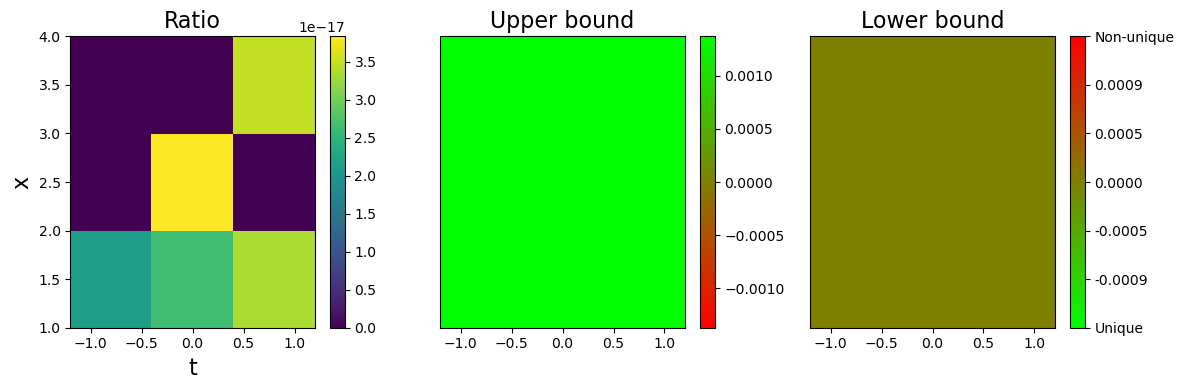

In [271]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
# Plot derivative results
subtitle_size=16
tickssize=16
order=fd_order
fig, axes = plt.subplots(1,3, figsize=(12,4))
#plt.suptitle(f'{order}nd order finite differences', fontsize=subtitle_size)

#Plot the ratios
c = axes[0].pcolor(t_grid, x_grid, svs)
axes[0].set_title('Ratio', fontsize=tickssize)
axes[0].set_ylabel('x', fontsize=tickssize)
axes[0].set_xlabel('t', fontsize=tickssize)
fig.colorbar(c, ax=axes[0])

upper_minus_svs = upper_bounds - svs
lower_minus_svs = svs-lower_bounds
max_svs= max(np.max(np.abs(upper_minus_svs)),np.max(np.abs(lower_minus_svs)))
#Plot difference to upper bound

axes[1].set_title('Upper bound', fontsize=tickssize)
c=axes[1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
axes[1].set_yticks([])
fig.colorbar(c, ax=axes[1])

#Plot difference to lower bound
lower_minus_svs = svs-lower_bounds
axes[2].set_title('Lower bound', fontsize=tickssize)
c = axes[2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_green_red, vmin=-max_svs, vmax=max_svs)
axes[2].set_yticks([])
cb = fig.colorbar(c, ax=axes[2])
ticks=np.linspace(-max_svs, max_svs,7) 
cb.set_ticks(ticks)
cb.set_ticklabels(['Unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Non-unique'])
plt.tight_layout()

In [265]:
ticks[5]

6.666666666666666e-11

In [266]:
ticks

array([-1.00000000e-10, -6.66666667e-11, -3.33333333e-11,  0.00000000e+00,
        3.33333333e-11,  6.66666667e-11,  1.00000000e-10])

In [ ]:
np.min(lower_minus_svs)

Function with unique PDE: $u(t,x)=(x+t)\arccos(sech(t))$
The function $u$ solves only the equation $u_t=u_x+\frac{u}{u_x}\cos(u)$.

In [3]:
experiment_name = 'analytic_unique_1'
n=200
u,x,t,formula = experiment_data(n_samples=n,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]
x_0, x_end =x[0], x[n-1]
t_0, t_end = t[0], t[n-1]

analytic_unique_1
(t + x)*acos(1/cosh(1.7497654730547*t))


As we do not include the cosine in the feature library, the models have problems computing a PDE.
## Check now numerically that this is the unique equation

We already know that the equation is unique as the image set has non-zero measure, so let us show this by using the Jacobi criterion for analytic function. First, we have to compute the additional derivatives.

In [6]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)
print((space_range,time_range))
fd_orders = [2, 7]
svs = jacobi_criterion(u,space_range,time_range,fd_orders)

(19, 19)


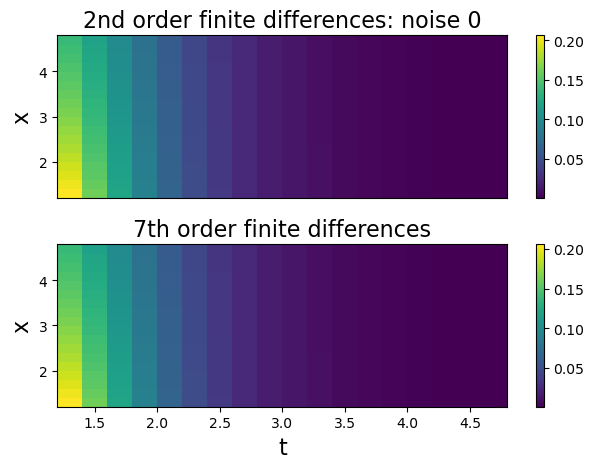

In [7]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
plot_result_jacobi(svs,t_grid,x_grid,target_noise=0,fd_orders=fd_orders)